In [1]:
from simulator import TerminationPolicy, Simulator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from scipy import stats

In [2]:
# SETTINGS
SEED = 42
WARMUP = False
warmup_events = 500
lambda_ = 1  # arrival_rate
mu = 1.5  # service_rate

os.makedirs("results", exist_ok=True) if not os.path.exists("results") else None
csv_name = (
    f"ex1_p1_mm1_{lambda_}_{mu}_warmup.csv" if WARMUP else f"mm1_{lambda_}_{mu}_nowarmup.csv"
)
path_to_csv = os.getcwd() + f"/results/{csv_name}.csv"

# delete the file if it exists
if os.path.exists(path_to_csv):
    os.remove(path_to_csv)

# Setup and run the simulator

In [3]:
# Termination policy: stop when the simulation time reaches 1,000 time units
policy = (
    TerminationPolicy()
    .add(lambda srv, sched, narr, ndep, abs_t: abs_t >= int(1e3))
    .all()
)

# Run the simulation
print(f"Running simulation with arrival rate: {lambda_}, service rate: {mu}")
sim = Simulator(
    arrival_rate=lambda_, service_rate=mu, seed=SEED, path_to_csv=path_to_csv
)
sim.run(termination_condition=policy)
sim.report()

Running simulation with arrival rate: 1, service rate: 1.5
Arrivals: 928
Departures: 926
Final queue length: 1
Server busy: True
Total Arrivals: 928
Total Services: 926


# Plots of Utilization and packets in the system

In [4]:
# Load the simulation results from the CSV file
data = pd.read_csv(path_to_csv)

if WARMUP:
    # remove first warmup_events
    data = data.iloc[warmup_events:]

# compute total packets in the system (queue + 1 if busy, else queue)
data["total_current_packets"] = data["queue_length"] + data["server_busy"].astype(int)

ro = lambda_ / mu
# Theoretical average number of packets in the system (stationary regime)
t_packet_mean = (
    ro / (1 - ro) if ro < 1 else np.inf
)  # if arrival rate >= service rate, the system is unstable (it saturates)

print(
    f"Average number of packets in the system: {data['total_current_packets'].mean():.4f} (theoretical: {t_packet_mean:.4f})"
)
# compute the average utilization
data["delta_t"] = data["time"].shift(-1) - data["time"]
data["delta_t"] = data["delta_t"].fillna(0.0)  # put to zero last value


data["cumulative_busy_time"] = (data["server_busy"] * data["delta_t"]).cumsum()
data["elapsed_time"] = data["time"] - data["time"].iloc[0]

data["cumulative_utilization"] = data["cumulative_busy_time"] / data["elapsed_time"]
data["cumulative_utilization"] = data["cumulative_utilization"].fillna(
    0.0
)  ##fill the Nan in first row

emp_util_mean = data["cumulative_utilization"].iloc[-1]

print(f"Utilization: {emp_util_mean:.4f} (theoretical: {lambda_ / mu:.4f})")

Average number of packets in the system: 1.9941 (theoretical: 2.0000)
Utilization: 0.5983 (theoretical: 0.6667)


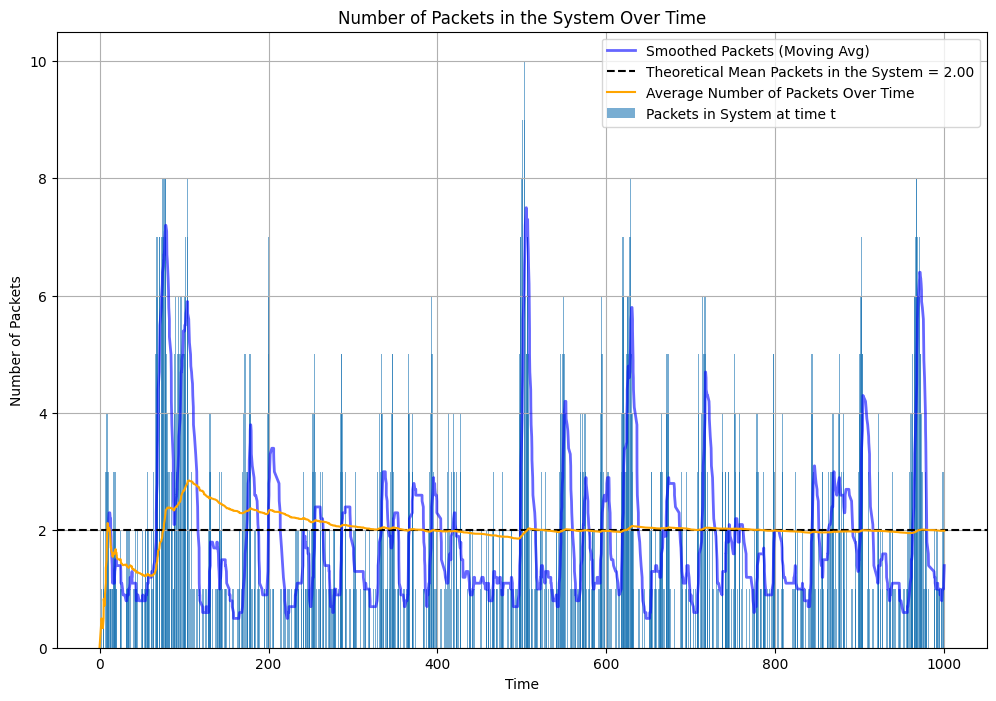

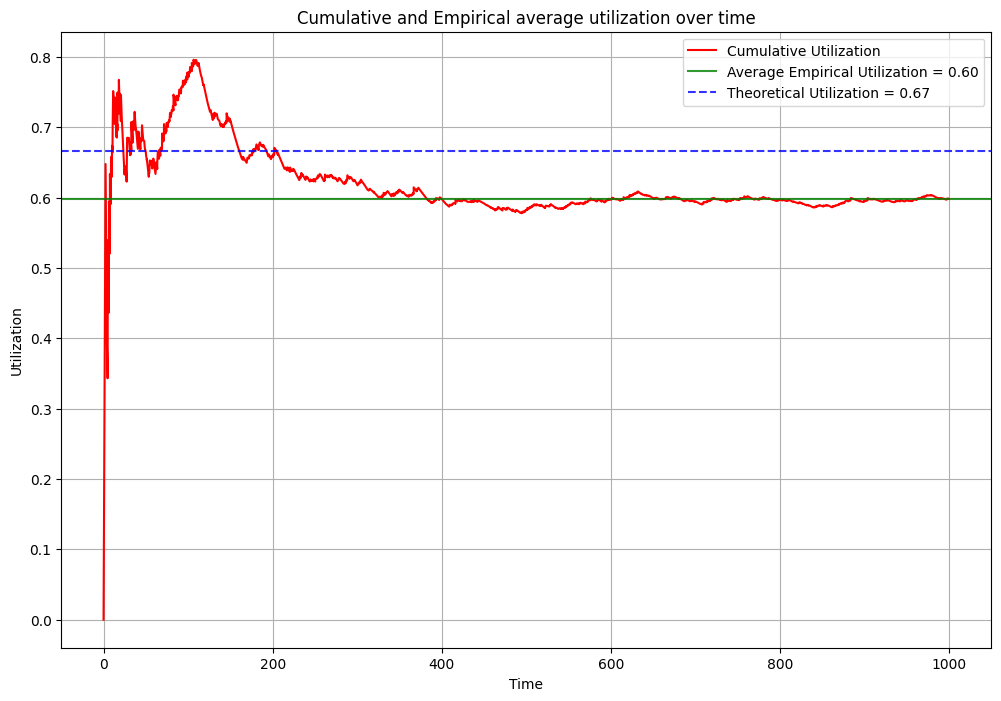

In [5]:
# Plot the number of packets in the system over time
plt.figure(figsize=(12, 8))
data["smoothed_packets"] = data["total_current_packets"].rolling(window=20).mean()
plt.plot(
    data["time"],
    data["smoothed_packets"],
    color="blue",
    label="Smoothed Packets (Moving Avg)",
    linewidth=2,
    alpha=0.6,
)
plt.bar(
    data["time"],
    data["total_current_packets"],
    label="Packets in System at time t",
    alpha=0.6,
)
plt.axhline(
    y=t_packet_mean,
    color="black",
    linestyle="--",
    label=f"Theoretical Mean Packets in the System = {t_packet_mean:.2f}",
)
plt.plot(
    data["time"],
    data["total_current_packets"].expanding().mean(),
    color="orange",
    label="Average Number of Packets Over Time",
)
plt.xlabel("Time")
plt.ylabel("Number of Packets")
plt.title("Number of Packets in the System Over Time")
plt.legend()
plt.grid()

plt.figure(figsize=(12, 8))
plt.plot(
    data["time"],
    data["cumulative_utilization"],
    label="Cumulative Utilization",
    color="red",
)
plt.axhline(
    emp_util_mean,
    color="green",
    label=f"Average Empirical Utilization = {emp_util_mean:.2f}",
    alpha=0.8,
)
plt.axhline(
    ro,
    color="blue",
    linestyle="--",
    label=f"Theoretical Utilization = {ro:.2f}",
    alpha=0.8,
)
plt.xlabel("Time")
plt.ylabel("Utilization")
plt.title("Cumulative and Empirical average utilization over time")
plt.legend()
plt.grid()
plt.show()

# Running simulation batches to assess the behavior of the system with different parameters

In [6]:
lamda_values = [0.5, 1.0, 1.5]
mu_values = [0.5, 1.0, 1.5]

NUM_REPLICATIONS = 20
NUM_TIME_UNITS = 500

seeds = range(SEED, SEED + NUM_REPLICATIONS)

policy = (
    TerminationPolicy()
    .add(lambda srv, sched, narr, ndep, abs_t: abs_t >= NUM_TIME_UNITS)
    .all()
)

# prepare to collect CSV paths
sim_results = []

# run simulations (unchanged)
for lambda_ in lamda_values:
    for mu in mu_values:
        for rep in range(NUM_REPLICATIONS):
            seed = seeds[rep]
            csv_name = f"ex1_p2_mm1_{lambda_}_{mu}_rep_{rep}"
            path_to_csv = os.path.join(os.getcwd(), "results", f"{csv_name}.csv")
            # Store metadata
            sim_results.append(
                {"lambda": lambda_, "mu": mu, "replication": rep, "path": path_to_csv}
            )

            sim = Simulator(
                arrival_rate=lambda_,
                service_rate=mu,
                seed=seed,
                path_to_csv=path_to_csv,
            )
            sim.run(termination_condition=policy)

In [7]:
def get_utils_results(
    grouped_results: dict, grid: np.ndarray, n_drops: int = 0
) -> dict:
    # Store averaged utilization curves for each (lambda, mu) pair
    utils_results = {}

    for (lambda_, mu), paths in grouped_results.items():
        utils_results[(lambda_, mu)] = {}

        utils_over_time_for_rep = np.zeros((len(paths), grid.size))
        utils_for_rep = np.zeros(len(paths))

        for i, csv_file in enumerate(paths):
            data = pd.read_csv(csv_file)
            # Drop the first n_drops rows
            data = data.iloc[n_drops:]

            # Compute delta_t, cumulative_busy_time, elapsed_time
            data["delta_t"] = data["time"].shift(-1) - data["time"]
            data.loc[data.index[-1], "delta_t"] = 0.0

            data["cumulative_busy_time"] = (
                data["server_busy"].astype(int) * data["delta_t"]
            ).cumsum()
            data["elapsed_time"] = data["time"] - data["time"].iloc[0]

            # Compute utilization, avoid divide-by-zero
            utilization = np.where(
                data["elapsed_time"] > 0,
                data["cumulative_busy_time"] / data["elapsed_time"],
                0.0,
            )

            utils_for_rep[i] = utilization[-1]

            # Interpolate onto the fixed grid
            utils_over_time_for_rep[i, :] = np.interp(
                grid, data["time"].values, utilization
            )

        utils_results[(lambda_, mu)]["utils_ot_rep"] = utils_over_time_for_rep

        # Average out the replications' avg utilization curves
        avg_util_curve = utils_over_time_for_rep.mean(axis=0)

        utils_results[(lambda_, mu)]["utils_ot_avg"] = avg_util_curve
        utils_results[(lambda_, mu)]["utils_for_rep"] = utils_for_rep

    return utils_results

## Visualization of the simulation results to identify the initialization phase

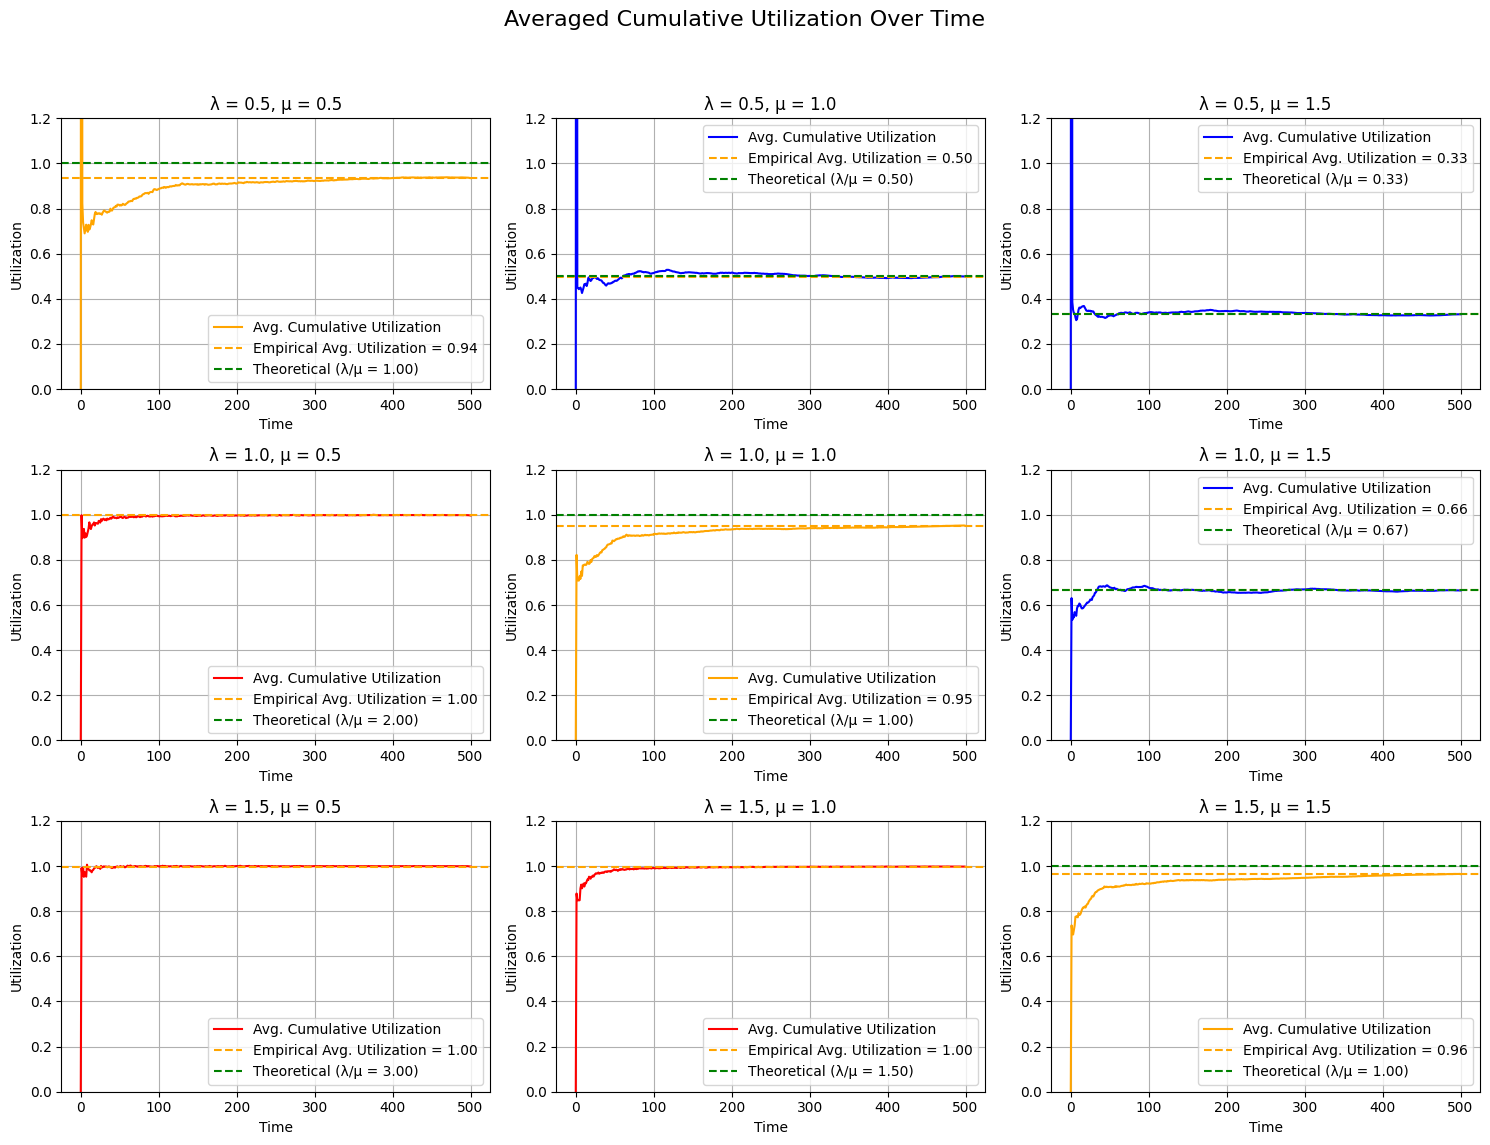

In [8]:
# Define a common time grid
grid = np.arange(0, NUM_TIME_UNITS + 1)  # integer times

# Group CSV results by (lambda, mu)
grouped_results = {}
for entry in sim_results:
    key = (entry["lambda"], entry["mu"])
    if key not in grouped_results:
        grouped_results[key] = []
    grouped_results[key].append(entry["path"])

utils_results = get_utils_results(grouped_results, grid)

# Determine the grid size for subplots
num_plots = len(utils_results)
cols = 3  # Choose how many columns you want
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

# Plot each utilization curve in a subplot
for idx, ((lambda_, mu), results) in enumerate(utils_results.items()):
    row, col = divmod(idx, cols)
    ax = axes[row][col]

    color = "blue" if mu > lambda_ else "red" if mu < lambda_ else "orange"

    theoretical_util = lambda_ / mu

    ax.plot(
        grid, results["utils_ot_avg"], color=color, label="Avg. Cumulative Utilization"
    )
    ax.axhline(
        results["utils_for_rep"].mean(),
        color="orange",
        linestyle="--",
        label=f"Empirical Avg. Utilization = {results['utils_for_rep'].mean():.2f}",
    )
    ax.axhline(
        theoretical_util,
        color="green",
        linestyle="--",
        label=f"Theoretical (λ/μ = {theoretical_util:.2f})",
    )
    ax.set_ylim(0, 1.2)
    ax.set_xlabel("Time")
    ax.set_ylabel("Utilization")
    ax.set_title(f"λ = {lambda_}, μ = {mu}")
    ax.grid()
    ax.legend()

fig.suptitle("Averaged Cumulative Utilization Over Time", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Removing the initialization phase from the results

In [9]:
# Drop the first events
NUM_DROPPED_EVENTS = 100

truncated_grid = grid[NUM_DROPPED_EVENTS:]

truncated_results = get_utils_results(
    grouped_results, truncated_grid, n_drops=NUM_DROPPED_EVENTS
)

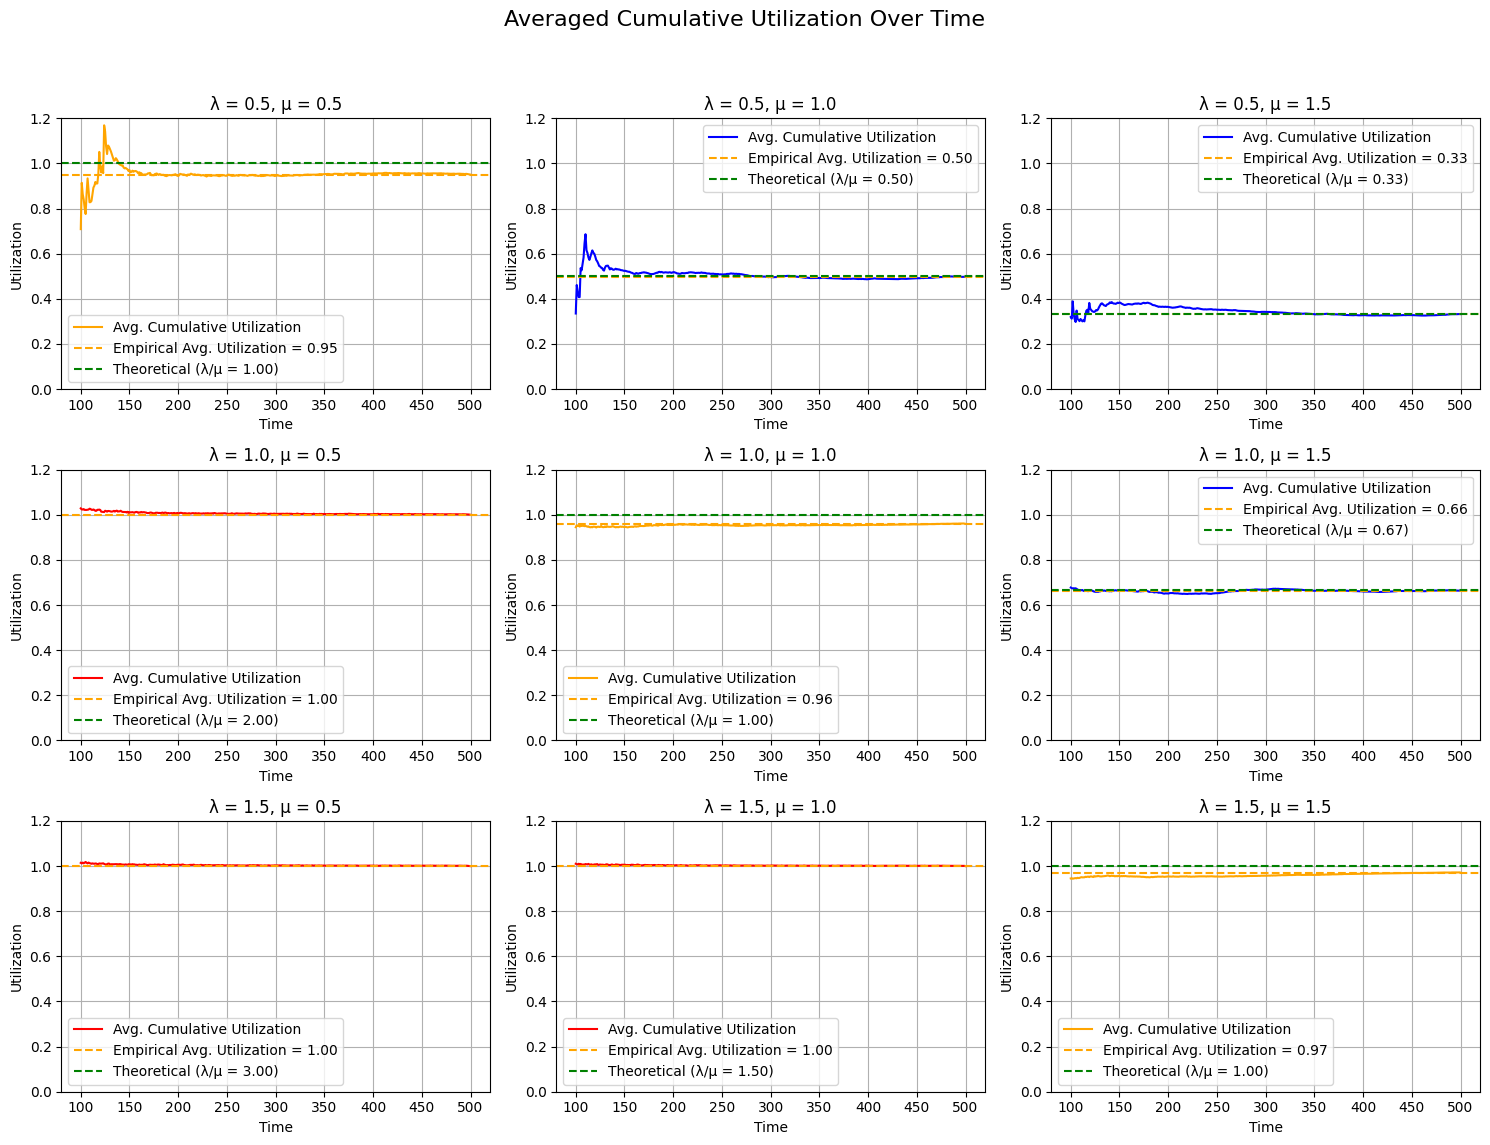

In [10]:
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

# Plot each utilization curve in a subplot
for idx, ((lambda_, mu), results) in enumerate(truncated_results.items()):
    row, col = divmod(idx, cols)
    ax = axes[row][col]

    color = "blue" if mu > lambda_ else "red" if mu < lambda_ else "orange"

    theoretical_util = lambda_ / mu

    ax.plot(
        truncated_grid,
        results["utils_ot_avg"],
        color=color,
        label="Avg. Cumulative Utilization",
    )
    ax.axhline(
        results["utils_for_rep"].mean(),
        color="orange",
        linestyle="--",
        label=f"Empirical Avg. Utilization = {results['utils_for_rep'].mean():.2f}",
    )
    ax.axhline(
        theoretical_util,
        color="green",
        linestyle="--",
        label=f"Theoretical (λ/μ = {theoretical_util:.2f})",
    )
    ax.set_ylim(0, 1.2)
    ax.set_xlabel("Time")
    ax.set_ylabel("Utilization")
    ax.set_title(f"λ = {lambda_}, μ = {mu}")
    ax.grid()
    ax.legend()

fig.suptitle("Averaged Cumulative Utilization Over Time", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
summary_rows = []

for (lambda_, mu), results in utils_results.items():
    # convert to numpy array for stats
    utils = results["utils_for_rep"]

    b = len(utils)
    t_quantile = stats.t.ppf(0.975, df=b - 1)  # 95% confidence interval

    mean_u = utils.mean()
    var_u = sum([(rep_mean - mean_u) ** 2 for rep_mean in utils]) / (
        b - 1
    )  # sample variance
    se_u = np.sqrt(var_u / b)

    ci_low, ci_high = mean_u - t_quantile * se_u, mean_u + t_quantile * se_u

    truncated_utils = truncated_results[(lambda_, mu)]["utils_for_rep"]

    truncated_mean_u = truncated_utils.mean()
    truncated_var_u = sum(
        [(rep_mean - truncated_mean_u) ** 2 for rep_mean in truncated_utils]
    ) / (
        b - 1
    )  # sample variance
    truncated_se_u = np.sqrt(truncated_var_u / b)
    truncated_ci_low, truncated_ci_high = (
        truncated_mean_u - t_quantile * truncated_se_u,
        truncated_mean_u + t_quantile * truncated_se_u,
    )

    # collect
    summary_rows.append(
        {
            "lambda": lambda_,
            "mu": mu,
            "n_reps": b,
            "theoretical": lambda_ / mu,
            "full": {
                "mean_util": mean_u,
                "var_util": var_u,
                "ci95_lo": ci_low,
                "ci95_hi": ci_high,
            },
            "truncated": {
                "mean_util": truncated_mean_u,
                "var_util": truncated_var_u,
                "ci95_lo": truncated_ci_low,
                "ci95_hi": truncated_ci_high,
            },
        }
    )

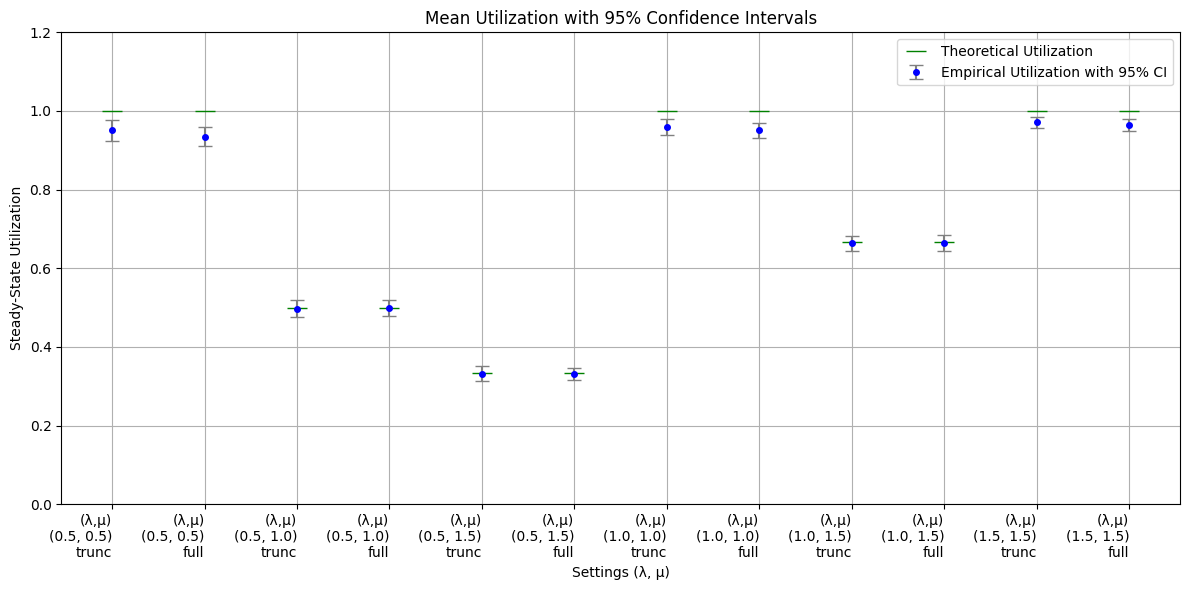

In [12]:
# Filter out rows where lambda is greater than mu
filtered_summaries = [row for row in summary_rows if row["lambda"] <= row["mu"]]

# Create labels
labels = []
y, yerr_lo, yerr_hi = [], [], []
theoretical_utils = []
for row in filtered_summaries:
    base_label = f"(λ,μ)\n({row['lambda']}, {row['mu']})\n"
    labels.append(base_label + "trunc")
    labels.append(base_label + "full")
    y.append(row["truncated"]["mean_util"])
    y.append(row["full"]["mean_util"])
    yerr_lo.append(row["truncated"]["mean_util"] - row["truncated"]["ci95_lo"])
    yerr_lo.append(row["full"]["mean_util"] - row["full"]["ci95_lo"])
    yerr_hi.append(row["truncated"]["ci95_hi"] - row["truncated"]["mean_util"])
    yerr_hi.append(row["full"]["ci95_hi"] - row["full"]["mean_util"])

    theoretical_utils.append(row["theoretical"])
    theoretical_utils.append(row["theoretical"])

yerr = np.array([yerr_lo, yerr_hi])
x = np.arange(len(labels))

# Compute error bars (asymmetrical)


# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, theoretical_utils, "g_", markersize=15, label="Theoretical Utilization")
plt.errorbar(
    x,
    y,
    yerr=yerr,
    fmt="o",
    capsize=5,
    markersize=4,
    color="blue",
    ecolor="gray",
    label="Empirical Utilization with 95% CI",
)

plt.xticks(x, labels, ha="right")
plt.ylim(0, 1.2)
plt.ylabel("Steady-State Utilization")
plt.xlabel("Settings (λ, μ)")
plt.title("Mean Utilization with 95% Confidence Intervals")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Exercise 2: estimate the average transit time of packets in the system

In [17]:
NUM_REPLICATIONS = 5
NUM_TIME_UNITS = 500

lambda_ = 1.0
mu = 1.5

seeds = range(SEED, SEED + NUM_REPLICATIONS)

policy = (
    TerminationPolicy()
    .add(lambda srv, sched, narr, ndep, abs_t: abs_t >= NUM_TIME_UNITS)
    .all()
)

# prepare to collect CSV paths
sim_results = []

for rep in range(NUM_REPLICATIONS):
    seed = seeds[rep]
    csv_name = f"ex2_mm1_{lambda_}_{mu}_rep_{rep}"
    path_to_csv = os.path.join(os.getcwd(), "results", f"{csv_name}.csv")
    # Store metadata
    sim_results.append(path_to_csv)

    sim = Simulator(
        arrival_rate=lambda_,
        service_rate=mu,
        seed=seed,
        path_to_csv=path_to_csv,
    )
    sim.run(termination_condition=policy)

## Naive approach: average the transit times of all packets

In [18]:
def get_transit_times(sim_results, drop_num=0):
    """
    Compute transit times from simulation results.

    :param sim_results: List of CSV file paths containing simulation results.
    :param drop_num: Number of initial events to drop from each simulation.
    :return: List of lists containing transit times for each replication.
    """
    transit_times_for_all_reps = np.empty(len(sim_results), dtype=object)

    for rep_idx, csv_file in enumerate(sim_results):
        data = pd.read_csv(csv_file)
        # data = data.iloc[drop_num:]  # drop the first `drop_num` events

        transit_times = []

        # Store arrival times to then compute transit times when the packet is served
        arrival_times = []

        # Store previous arr/dep counts to understand the current type of event
        prev_arrivals = data["arrivals"].iloc[0]
        prev_departures = data["departures"].iloc[0]

        for i, row in data.iterrows():
            if prev_arrivals < row["arrivals"]:
                # This is an arrival event
                prev_arrivals += 1

                arrival_times.append(row["time"])
            elif prev_departures < row["departures"]:
                # This is a departure event
                prev_departures += 1

                cur_packet_at = arrival_times.pop(0)  # Get the first arrival time
                if i >= drop_num:  # drop the first `drop_num` events
                    transit_time = row["time"] - cur_packet_at
                    transit_times.append(transit_time)

        transit_times_for_all_reps[rep_idx] = transit_times

    return transit_times_for_all_reps

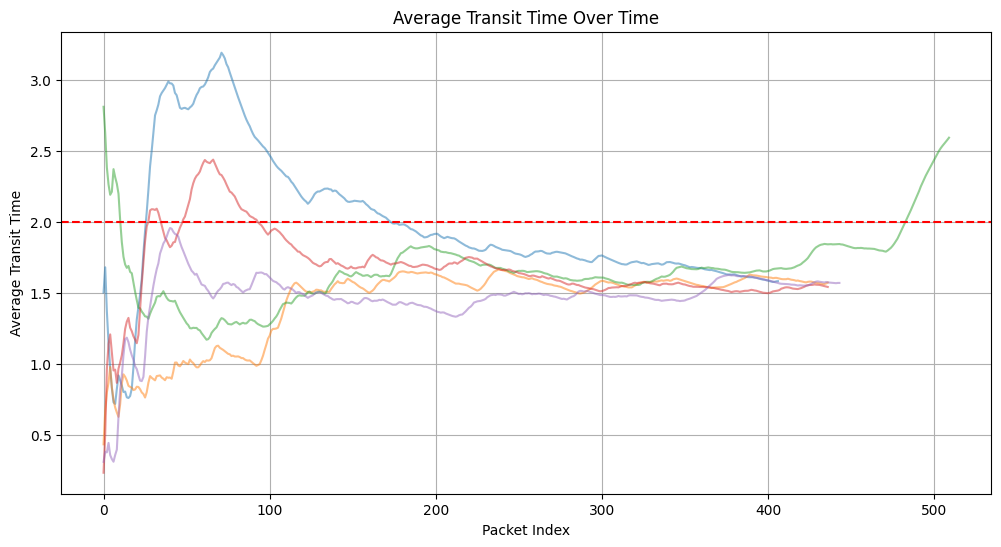

In [ ]:
plt.figure(figsize=(12, 6))

transit_times_for_rep = get_transit_times(sim_results, drop_num=0)

for rep in transit_times_for_rep:
    avg_transit_time_over_time = np.cumsum(rep) / np.arange(1, len(rep) + 1)
    plt.plot(
        avg_transit_time_over_time, alpha=0.5, label="Cumulative Mean Transit Time"
    )

    # plt.plot(rep, alpha=0.1, label="Replication Transit Times")

plt.axhline(
    y=1 / (mu - lambda_),
    label="Theoretical Mean Transit Time",
    color="red",
    linestyle="--",
)

plt.xlabel("Packet Index")
plt.ylabel("Average Transit Time")
plt.title("Average Transit Time Over Time")
plt.grid()
plt.show()

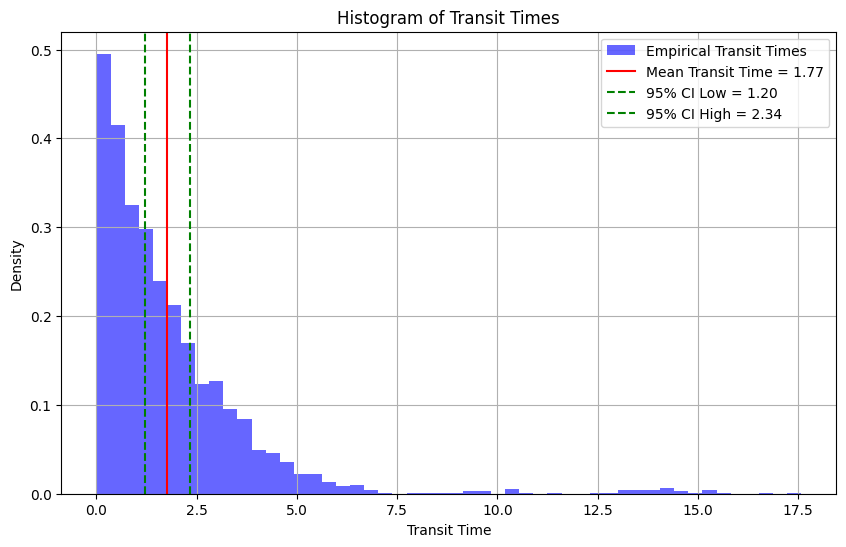

In [22]:
# Plot the histogram of transit times

all_transit_times = np.concatenate(transit_times_for_rep)

mean_tt_for_rep = np.array([np.mean(rep) for rep in transit_times_for_rep])


b = len(mean_tt_for_rep)  # Number of IRs
tt_mean = mean_tt_for_rep.mean()
tt_var = sum([(rep_mean - tt_mean) ** 2 for rep_mean in mean_tt_for_rep]) / (
    b - 1
)  # sample variance
t_quantile = stats.t.ppf(0.975, df=b - 1)
se = np.sqrt(tt_var / b)  # standard error
mean_ci_low, mean_ci_high = tt_mean - t_quantile * se, tt_mean + t_quantile * se

plt.figure(figsize=(10, 6))
plt.hist(
    all_transit_times,  # Use the flattened array of transit times
    # mean_transit_times,
    bins=50,
    density=True,
    alpha=0.6,
    color="blue",
    label="Empirical Transit Times",
)
plt.axvline(
    mean_tt_for_rep.mean(),
    color="red",
    label=f"Mean Transit Time = {mean_tt_for_rep.mean():.2f}",
)
plt.axvline(
    mean_ci_low,
    color="green",
    linestyle="--",
    label=f"95% CI Low = {mean_ci_low:.2f}",
)
plt.axvline(
    mean_ci_high,
    color="green",
    linestyle="--",
    label=f"95% CI High = {mean_ci_high:.2f}",
)
plt.xlabel("Transit Time")
plt.ylabel("Density")
plt.title("Histogram of Transit Times")
plt.grid()
plt.legend()
plt.show()